# 深層学習を用いた「オセロAI」_AlphaZero

## ゲーム環境の構築


In [ ]:
# セル1: ゲーム環境

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class OthelloGame:
    # ... (前回のOthelloGameクラスのコードをここに貼り付け) ...
    def __init__(self, n=8):
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        self.board[mid-1, mid-1] = self.board[mid, mid] = 1
        self.board[mid-1, mid] = self.board[mid, mid-1] = -1
        self.current_player = -1
    def get_valid_moves(self, player):
        valid_moves = []
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r, c] == 0:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0: continue
                            r_check, c_check = r + dr, c + dc
                            flipped_stones = []
                            while 0 <= r_check < self.n and 0 <= c_check < self.n:
                                if self.board[r_check, c_check] == -player:
                                    flipped_stones.append((r_check, c_check))
                                    r_check += dr
                                    c_check += dc
                                elif self.board[r_check, c_check] == player:
                                    if flipped_stones: valid_moves.append((r, c))
                                    break
                                else: break
        return list(set(valid_moves))
    def make_move(self, move, player):
        if move is None: return
        r, c = move
        self.board[r, c] = player
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0: continue
                r_check, c_check = r + dr, c + dc
                flipped_stones = []
                while 0 <= r_check < self.n and 0 <= c_check < self.n:
                    if self.board[r_check, c_check] == -player:
                        flipped_stones.append((r_check, c_check))
                        r_check += dr
                        c_check += dc
                    elif self.board[r_check, c_check] == player:
                        for fr, fc in flipped_stones: self.board[fr, fc] = player
                        break
                    else: break
    def is_game_over(self):
        return not self.get_valid_moves(-1) and not self.get_valid_moves(1)
    def get_winner(self):
        black_stones = np.sum(self.board == -1)
        white_stones = np.sum(self.board == 1)
        if black_stones > white_stones: return -1
        elif white_stones > black_stones: return 1
        else: return 0
    def get_board_state(self):
        return self.board.copy()
    def get_symmetries(self, board, pi):
        pi_board = np.reshape(pi, (self.n, self.n))
        symmetries = []
        for i in range(4):
            for j in [True, False]:
                new_b = np.rot90(board, i)
                new_pi = np.rot90(pi_board, i)
                if j:
                    new_b = np.fliplr(new_b)
                    new_pi = np.fliplr(new_pi)
                symmetries.append((new_b, new_pi.flatten()))
        return symmetries

## ニューラルネットワークとMCTSの実装
AlphaZero方式の心臓部です。ResNet風の構造を持つネットワークと、MCTSのロジックを実装

In [ ]:
# セル2: ニューラルネットワークとMCTS


# --- 1. ニューラルネットワーク ---
class ResBlock(nn.Module):
    # ... (変更なし) ...
    def __init__(self, num_filters):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class AlphaNet(nn.Module):
    # num_res_blocksを引数で受け取れるように変更
    def __init__(self, n=8, num_res_blocks=5, num_filters=64):
        super(AlphaNet, self).__init__()
        self.n = n
        self.start_block = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.res_blocks = nn.ModuleList([ResBlock(num_filters) for _ in range(num_res_blocks)])
        self.policy_conv = nn.Conv2d(num_filters, 2, kernel_size=1)
        self.policy_fc = nn.Linear(2 * n * n, n * n)
        self.value_conv = nn.Conv2d(num_filters, 1, kernel_size=1)
        self.value_fc1 = nn.Linear(n * n, 256)
        self.value_fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, 1, self.n, self.n)
        x = self.start_block(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        pi = F.relu(self.policy_conv(x))
        pi = pi.view(pi.size(0), -1)
        pi = self.policy_fc(pi)
        pi = F.log_softmax(pi, dim=1)
        v = F.relu(self.value_conv(x))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))
        return pi, v

# --- 2. モンテカルロ木探索 (MCTS) ---
class MCTS:
    # ... (前回の修正版MCTSクラスのコードをここに貼り付け) ...
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}
        self.Nsa = {}
        self.Ns = {}
        self.Ps = {}
    def get_action_prob(self, canonical_board, temp=1):
        for _ in range(self.args['num_sims']):
            sim_game = OthelloGame(self.game.n)
            sim_game.board = np.copy(canonical_board)
            sim_game.current_player = 1
            self.search(sim_game)
        s = str(canonical_board.tobytes())
        counts = [self.Nsa.get((s, a), 0) for a in range(self.game.n * self.game.n)]
        if temp == 0:
            best_a = np.argmax(counts)
            probs = [0] * len(counts)
            probs[best_a] = 1
            return probs
        counts = [c**(1./temp) for c in counts]
        probs_sum = float(sum(counts))
        if probs_sum == 0:
            valid_moves = self.game.get_valid_moves(1)
            num_valid_moves = len(valid_moves)
            probs = [0] * len(counts)
            if num_valid_moves > 0:
                prob_per_move = 1 / num_valid_moves
                for r, c in valid_moves:
                    probs[r * self.game.n + c] = prob_per_move
            return probs
        probs = [x / probs_sum for x in counts]
        return probs
    def search(self, sim_game):
        s = str(sim_game.board.tobytes())
        if sim_game.is_game_over():
            return -sim_game.get_winner()
        if s not in self.Ps:
            board_tensor = torch.FloatTensor(sim_game.board).unsqueeze(0).to(self.args['device'])
            log_pi, v = self.nnet(board_tensor)
            self.Ps[s] = torch.exp(log_pi).data.cpu().numpy()[0]
            self.Ns[s] = 0
            return -v.item()
        valid_moves = sim_game.get_valid_moves(sim_game.current_player)
        if not valid_moves:
            sim_game.current_player *= -1
            return -self.search(sim_game)
        valid_actions = [r * self.game.n + c for r, c in valid_moves]
        best_uct = -float('inf')
        best_a = -1
        for a in valid_actions:
            if (s, a) in self.Qsa:
                uct = self.Qsa[(s, a)] + self.args['cpuct'] * self.Ps[s][a] * np.sqrt(self.Ns[s]) / (1 + self.Nsa[(s, a)])
            else:
                uct = self.args['cpuct'] * self.Ps[s][a] * np.sqrt(self.Ns[s] + 1e-8)
            if uct > best_uct:
                best_uct = uct
                best_a = a
        a = best_a
        next_sim_game = OthelloGame(self.game.n)
        next_sim_game.board = np.copy(sim_game.board)
        next_sim_game.current_player = sim_game.current_player
        next_sim_game.make_move((a // self.game.n, a % self.game.n), next_sim_game.current_player)
        next_sim_game.current_player *= -1
        v = self.search(next_sim_game)
        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1
        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1
        self.Ns[s] += 1
        return -v

## アリーナの実装
2つの異なるネットワークモデルを対戦させるためのクラスを新しく作成




In [ ]:
# セル3: アリーナと学習クラス

class Arena():
    # ... (前回のArenaクラスのコードをここに貼り付け) ...
    def __init__(self, player1, player2, game, args):
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.args = args
    def playGame(self, verbose=False):
        players = [self.player2, None, self.player1]
        current_player_idx = -1
        game = OthelloGame(self.game.n)
        it = 0
        while not game.is_game_over():
            it += 1
            player_in_turn = players[current_player_idx + 1]
            canonical_board = game.get_board_state() * current_player_idx
            mcts = MCTS(OthelloGame(self.game.n), player_in_turn, self.args)
            mcts.game.board = np.copy(game.board)
            mcts.game.current_player = current_player_idx
            action_probs = mcts.get_action_prob(canonical_board, temp=0)
            action = np.argmax(action_probs)
            game.make_move((action // self.game.n, action % self.game.n), current_player_idx)
            current_player_idx *= -1
        return game.get_winner()
    def playGames(self, num_games, verbose=False):
        num_games = int(num_games / 2)
        one_wins = 0
        two_wins = 0
        draws = 0
        for _ in tqdm(range(num_games), desc="Arena (P1 vs P2)"):
            game_result = self.playGame(verbose=verbose)
            if game_result == -1: one_wins += 1
            elif game_result == 1: two_wins += 1
            else: draws += 1
        self.player1, self.player2 = self.player2, self.player1
        for _ in tqdm(range(num_games), desc="Arena (P2 vs P1)"):
            game_result = self.playGame(verbose=verbose)
            if game_result == 1: one_wins += 1
            elif game_result == -1: two_wins += 1
            else: draws += 1
        return one_wins, two_wins, draws

class Coach:
    # ... (前回のCoachクラスのコードをここに貼り付け) ...
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.pnet = self.nnet.__class__(game.n, num_res_blocks=args['num_res_blocks']).to(args['device'])
        self.args = args
        self.train_examples_history = []
        self.optimizer = optim.Adam(self.nnet.parameters(), lr=args['lr'])
    def execute_episode(self):
        train_examples = []
        game = OthelloGame(self.game.n)
        current_player = -1
        episode_step = 0
        while True:
            episode_step += 1
            canonical_board = game.get_board_state() * current_player
            temp = int(episode_step < self.args['temp_threshold'])
            mcts = MCTS(OthelloGame(self.game.n), self.nnet, self.args)
            mcts.game.board = np.copy(game.board)
            mcts.game.current_player = current_player
            pi = mcts.get_action_prob(canonical_board, temp=temp)
            for b, p in self.game.get_symmetries(canonical_board, pi):
                train_examples.append([b, current_player, p])
            action = np.random.choice(len(pi), p=pi)
            game.make_move((action // self.game.n, action % self.game.n), current_player)
            if game.is_game_over():
                winner = game.get_winner()
                return [(x[0], x[2], winner * x[1]) for x in train_examples]
            current_player *= -1
    def learn(self):
        for i in range(1, self.args['num_iters'] + 1):
            iteration_train_examples = deque(maxlen=self.args['max_len_of_queue'])
            for _ in tqdm(range(self.args['num_episodes']), desc=f"Self Play (Iter {i})"):
                iteration_train_examples += self.execute_episode()
            self.train_examples_history.append(iteration_train_examples)
            if len(self.train_examples_history) > self.args['num_iters_for_train_examples_history']:
                self.train_examples_history.pop(0)
            train_examples = []
            for e in self.train_examples_history:
                train_examples.extend(e)
            random.shuffle(train_examples)
            self.pnet.load_state_dict(self.nnet.state_dict())
            self.train(train_examples)
            arena = Arena(self.nnet, self.pnet, self.game, self.args)
            pwins, nwins, draws = arena.playGames(self.args['arena_compare'])
            if nwins + pwins > 0 and nwins/(nwins+pwins) > self.args['update_threshold']:
                self.nnet.state_dict()
            else:
                self.nnet.load_state_dict(self.pnet.state_dict())
    def train(self, examples):
        self.nnet.train()
        for epoch in range(self.args['epochs']):
            batch_count = int(len(examples) / self.args['batch_size'])
            for _ in range(batch_count):
                sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = torch.FloatTensor(np.array(boards)).to(self.args['device'])
                target_pis = torch.FloatTensor(np.array(pis)).to(self.args['device'])
                target_vs = torch.FloatTensor(np.array(vs)).to(self.args['device'])
                out_pi, out_v = self.nnet(boards)
                l_pi = -torch.sum(target_pis * out_pi) / target_pis.size()[0]
                l_v = F.mse_loss(out_v.view(-1), target_vs)
                total_loss = l_pi + l_v
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

## 学習の実装
学習ループにアリーナでの評価を追加し、結果をhistoryに記録

In [ ]:
# セル4: メイン処理 - 2つのモデルの学習と直接対決


# --- 1. パラメータ設定 ---
# 共通設定
COMMON_ARGS = {
    'num_iters': 5,                   # 総学習イテレーション数
    'temp_threshold': 15,
    'cpuct': 1.0,
    'arena_compare': 10,              # モデル更新時の評価対戦数
    'update_threshold': 0.55,
    'lr': 0.001,
    'epochs': 5,
    'batch_size': 64,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'max_len_of_queue': 200000,
    'num_iters_for_train_examples_history': 20,
}

# ベースモデルのパラメータ
args_base = COMMON_ARGS.copy()
args_base.update({
    'num_res_blocks': 5,      # ネットワークの深さ
    'num_sims': 20,           # MCTS探索回数
    'num_episodes': 10,       # 自己対戦ゲーム数
})

# 強化モデルのパラメータ
args_enhanced = COMMON_ARGS.copy()
args_enhanced.update({
    'num_res_blocks': 8,      # 深くする
    'num_sims': 40,           # 探索回数を増やす
    'num_episodes': 20,       # 自己対戦数を増やす
})

# --- 2. ベースモデルの学習 ---
print("--- START TRAINING: BASE MODEL ---")
print(f"Device: {args_base['device']}")
game = OthelloGame()
base_nnet = AlphaNet(n=game.n, num_res_blocks=args_base['num_res_blocks']).to(args_base['device'])
coach_base = Coach(game, base_nnet, args_base)
coach_base.learn()
torch.save(base_nnet.state_dict(), 'base_model.pth')
print("\n--- FINISHED TRAINING: BASE MODEL ---")


# --- 3. 強化モデルの学習 ---
print("\n\n--- START TRAINING: ENHANCED MODEL ---")
print(f"Device: {args_enhanced['device']}")
enhanced_nnet = AlphaNet(n=game.n, num_res_blocks=args_enhanced['num_res_blocks']).to(args_enhanced['device'])
coach_enhanced = Coach(game, enhanced_nnet, args_enhanced)
coach_enhanced.learn()
torch.save(enhanced_nnet.state_dict(), 'enhanced_model.pth')
print("\n--- FINISHED TRAINING: ENHANCED MODEL ---")


# --- 4. 最終決戦：ベース vs 強化 ---
print("\n\n--- FINAL SHOWDOWN: BASE vs ENHANCED ---")
# チャンピオンシップ用の探索回数（両者同条件）
showdown_args = COMMON_ARGS.copy()
showdown_args['num_sims'] = 30

# モデルをロード
base_model = AlphaNet(n=game.n, num_res_blocks=args_base['num_res_blocks']).to(args_base['device'])
base_model.load_state_dict(torch.load('base_model.pth'))
base_model.eval()

enhanced_model = AlphaNet(n=game.n, num_res_blocks=args_enhanced['num_res_blocks']).to(args_enhanced['device'])
enhanced_model.load_state_dict(torch.load('enhanced_model.pth'))
enhanced_model.eval()

# アリーナで対決
arena = Arena(player1=enhanced_model, player2=base_model, game=game, args=showdown_args)
enhanced_wins, base_wins, draws = arena.playGames(40) # 40ゲームで対決

print("\n--- SHOWDOWN RESULTS ---")
print(f"Enhanced Model Wins: {enhanced_wins}")
print(f"Base Model Wins: {base_wins}")
print(f"Draws: {draws}")

# 結果を保存（可視化用）
showdown_results = {
    'Enhanced Model': enhanced_wins,
    'Base Model': base_wins,
    'Draws': draws
}

--- START TRAINING: BASE MODEL ---
Device: cuda


Arena (P2 vs P1): 100%|██████████| 5/5 [00:21<00:00,  4.20s/it]



--- FINISHED TRAINING: BASE MODEL ---


--- START TRAINING: ENHANCED MODEL ---
Device: cuda


Arena (P2 vs P1): 100%|██████████| 5/5 [00:55<00:00, 11.10s/it]



--- FINISHED TRAINING: ENHANCED MODEL ---


--- FINAL SHOWDOWN: BASE vs ENHANCED ---


Arena (P2 vs P1): 100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


--- SHOWDOWN RESULTS ---
Enhanced Model Wins: 20
Base Model Wins: 20
Draws: 0


## 実行と可視化
学習パラメータにアリーナ関連のものを追加し、最後にグラフを描画するコードを付け加える

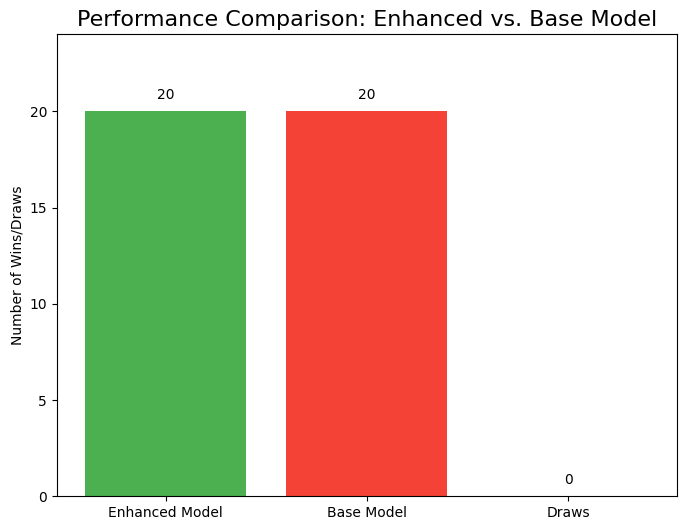

In [ ]:
# セル5: 結果の可視化

if 'showdown_results' in locals():
    labels = list(showdown_results.keys())
    values = list(showdown_results.values())

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, values, color=['#4CAF50', '#F44336', '#9E9E9E'])

    ax.set_ylabel('Number of Wins/Draws')
    ax.set_title('Performance Comparison: Enhanced vs. Base Model', fontsize=16)
    ax.set_ylim(0, max(values) * 1.2)

    # バーの上に数値を表示
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.show()
else:
    print("学習と対決が完了していません。セル4を先に実行してください。")

##